In [28]:
# [Cell 1] 라이브러리 임포트
import pandas as pd
import numpy as np
import json
import joblib
import lightgbm as lgb
from datetime import datetime



from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 모델링 및 평가 관련
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    precision_recall_curve, auc, accuracy_score, 
    precision_score, recall_score, f1_score, classification_report
)
from sklearn.preprocessing import LabelEncoder

# 경고 무시 (깔끔한 출력을 위해)
import warnings
warnings.filterwarnings('ignore')


In [51]:
# 데이터 불러오기
features = pd.read_parquet("/Users/kimjiwoo/Documents/SKN23-2nd-3Team/data/features_ml_clean.parquet")
labels = pd.read_parquet("/Users/kimjiwoo/Documents/SKN23-2nd-3Team/data/labels.parquet")

features.columns

Index(['user_id', 'anchor_time', 'n_events_30d', 'active_days_30d',
       'n_purchase_30d', 'purchase_ratio', 'days_since_last_event',
       'days_since_last_purchase', 'brand_concentration_ratio',
       'brand_switch_count_30d', 'total_spend_30d', 'activity_ratio_15d',
       'price_volatility', 'n_events_7d', 'visit_regularity',
       'activity_trend'],
      dtype='object')

In [6]:
labels.head()

,user_id,anchor_time,home_brand,future_brand,label,split
0,113868975,2020-01-31,apple,apple,m0,train
1,113868975,2020-02-29,apple,apple,m0,val
2,113868975,2020-03-31,apple,apple,m0,test
3,177507559,2019-12-31,samsung,,m2,train
4,178740206,2020-02-29,xiaomi,,m2,val


In [8]:
features["user_id"] = features["user_id"].astype(str)
labels["user_id"]   = labels["user_id"].astype(str)

features["anchor_time"] = pd.to_datetime(features["anchor_time"])
labels["anchor_time"]   = pd.to_datetime(labels["anchor_time"])

df = features.merge(
    labels[["user_id","anchor_time","label","split"]],
    on=["user_id","anchor_time"],
    how="inner",
    validate="one_to_one"
)

In [10]:
df["y_bin"] = (df["label"] == "m2").astype(int)

In [11]:
df.head()

,user_id,anchor_time,n_events_30d,active_days_30d,n_purchase_30d,purchase_ratio,days_since_last_event,days_since_last_purchase,brand_concentration_ratio,brand_switch_count_30d,total_spend_30d,activity_ratio_15d,price_volatility,n_events_7d,visit_regularity,activity_trend,label,split,y_bin
0,113868975,2020-01-31,17,8,0,0.00,0.446910,31.000000,0.588235,9,0.00,0.705882,0.0,8.0,1.494799,0.470588,m0,train,0
1,113868975,2020-02-29,6,5,0,0.00,3.373669,31.000000,0.833333,1,0.00,0.500000,0.0,0.0,5.818645,0.000000,m0,val,0
2,113868975,2020-03-31,2,2,0,0.00,23.379780,31.000000,1.000000,0,0.00,0.000000,0.0,0.0,-1.000000,0.000000,m0,test,0
3,177507559,2019-12-31,4,1,1,0.25,26.808588,26.808831,1.000000,0,154.16,0.000000,0.0,0.0,0.001010,0.000000,m2,train,1
4,178740206,2020-02-29,2,2,0,0.00,13.254109,31.000000,1.000000,0,0.00,0.500000,0.0,0.0,-1.000000,0.000000,m2,val,1


In [13]:
feature_cols = [c for c in df.columns if c not in ["user_id","anchor_time","label","split","y_bin"]]

In [35]:
X_train = df[df.split=="train"][feature_cols]
y_train = df[df.split=="train"]["y_bin"]

X_test  = df[df.split=="test"][feature_cols]
y_test  = df[df.split=="test"]["y_bin"]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (574092, 14), Test: (101833, 14)


In [15]:
lgbm = LGBMClassifier(
    n_estimators=1000,       # 트리 개수 증가 (성능 향상)
    learning_rate=0.05,      # 학습률 조정
    num_leaves=31,           # 리프 노드 수 (복잡도 제어)
    max_depth=-1,            # 깊이 제한 없음 (num_leaves로 제어)
    min_child_samples=20,    # 과적합 방지
    is_unbalance=True,       # 핵심: 이탈자(m2) 가중치 자동 부여
    n_jobs=-1,               # 병렬 처리
    random_state=42,
    verbose=-1               # 불필요한 로그 생략
)

print("Training LightGBM...")
lgbm.fit(X_train, y_train) # hgb -> lgbm

Training LightGBM...


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [21]:
prob_lgbm = lgbm.predict_proba(X_test)[:,1] 

def cumulative_recall(y, p, steps=100):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    total = df.y.sum()
    xs, ys = [], []
    for k in range(1, steps+1):
        r = k/steps
        ys.append(df.iloc[:int(len(df)*r)].y.sum()/total)
        xs.append(r)
    return xs, ys


x, r_lgbm = cumulative_recall(y_test.values, prob_lgbm) 

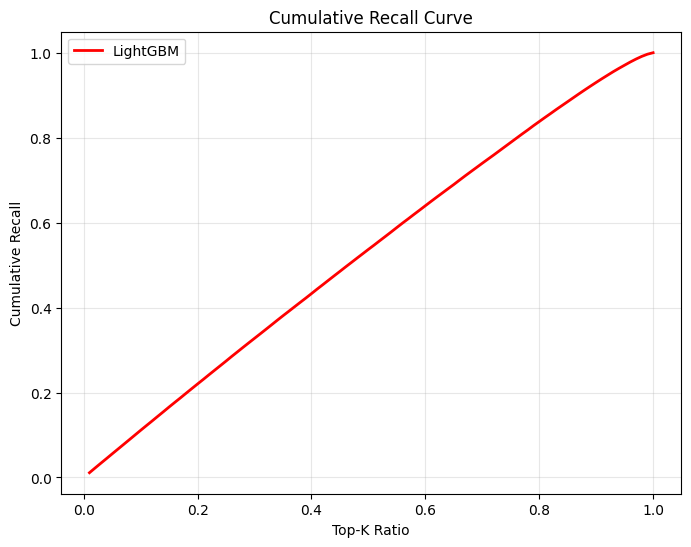

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(x, r_lgbm, label="LightGBM", linewidth=2, color='red') # 라벨 변경 & 강조
plt.xlabel("Top-K Ratio")
plt.ylabel("Cumulative Recall")
plt.title("Cumulative Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
COST = 1
VALUE = 10

def roi_curve(y, p):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    ratios = np.linspace(0.01, 0.2, 20)
    rois = []
    for r in ratios:
        k = int(len(df)*r)
        if k == 0: k = 1 # division by zero 방지
        hit = df.iloc[:k].y.sum()
        rois.append((hit*VALUE - k*COST)/(k*COST))
    return ratios, rois


x, roi_lgbm = roi_curve(y_test.values, prob_lgbm) # hgb -> lgbm

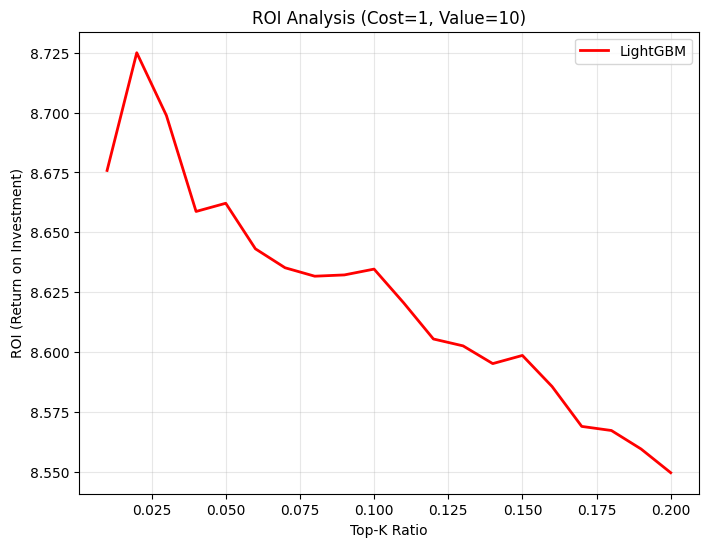

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(x, roi_lgbm, label="LightGBM", linewidth=2, color='red')
plt.xlabel("Top-K Ratio")
plt.ylabel("ROI (Return on Investment)")
plt.title("ROI Analysis (Cost=1, Value=10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Calculating Feature Importance...


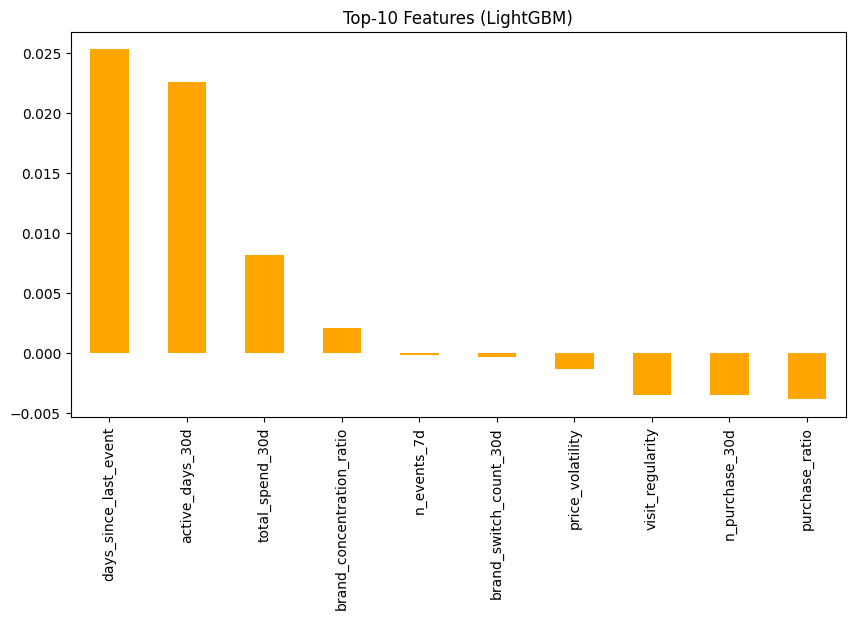

In [29]:
# 변수 중요도 (Permutation Importance)
print("Calculating Feature Importance...")
imp_lgbm = permutation_importance(lgbm, X_test, y_test, n_repeats=5, random_state=42) # hgb -> lgbm


plt.figure(figsize=(10, 5))
pd.Series(imp_lgbm.importances_mean, index=X_test.columns)\
  .sort_values(ascending=False).head(10)\
  .plot(kind="bar", title="Top-10 Features (LightGBM)", color='orange')
plt.show()

<Figure size 1200x500 with 0 Axes>

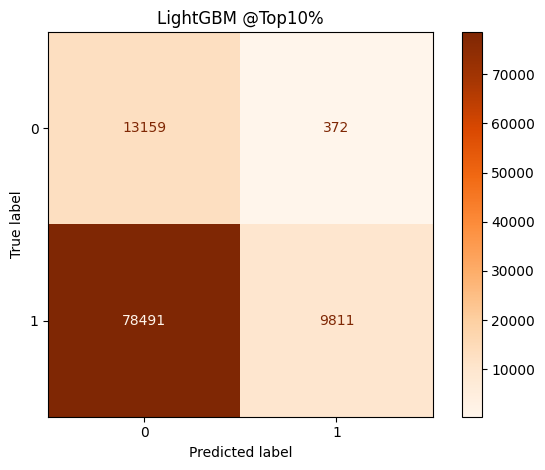

In [33]:
# 혼동행렬
def cm_topk(y, p, k=0.1):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    df["pred"] = 0
    df.iloc[:int(len(df)*k), df.columns.get_loc("pred")] = 1
    return confusion_matrix(df.y, df.pred)

plt.figure(figsize=(12, 5))

ConfusionMatrixDisplay(cm_topk(y_test, prob_lgbm)).plot(cmap='Oranges')
plt.title("LightGBM @Top10%") # hgb -> lgbm

plt.tight_layout()
plt.show()

Accuracy: 0.7189
Error Rate: 0.2811


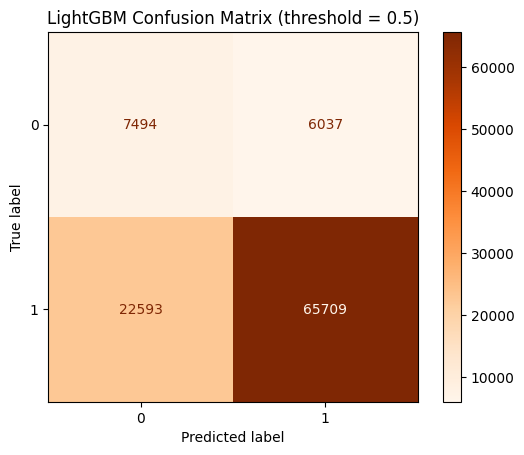

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# threshold = 0.5
# [수정] prob_hgb -> prob_lgbm (LightGBM 예측 확률 사용)
y_pred_lgbm = (prob_lgbm >= 0.5).astype(int)

cm_full = confusion_matrix(y_test, y_pred_lgbm)
acc = accuracy_score(y_test, y_pred_lgbm)
error_rate = 1 - acc

print(f"Accuracy: {acc:.4f}")
print(f"Error Rate: {error_rate:.4f}")

# [수정] HGB -> LightGBM으로 제목 변경
# cmap='Oranges'를 추가하면 LightGBM의 테마색(주황)과 어울립니다.
ConfusionMatrixDisplay(cm_full).plot(values_format="d", cmap='Oranges') 
plt.title("LightGBM Confusion Matrix (threshold = 0.5)")
plt.show()

### 튜닝 단계

In [36]:
# [Cell 3]
print("🚀 LightGBM 하이퍼파라미터 튜닝 시작...")

# 1. 기본 모델 (불균형 데이터 처리 포함)
lgbm_base = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    is_unbalance=True,       # [핵심] 18.5% 이탈자 데이터 가중치 자동 보정
    boost_from_average=False,
    verbose=-1
)

# 2. 파라미터 탐색 범위
param_dist = {
    'n_estimators': [500, 1000, 1500],    # 트리 개수
    'learning_rate': [0.01, 0.03, 0.05],  # 학습률
    'num_leaves': [31, 63, 127],          # 복잡도
    'max_depth': [-1, 10, 15],            # 깊이 제한
    'min_child_samples': [20, 50, 100],   # 과적합 방지
    'subsample': [0.7, 0.8, 0.9],         # 데이터 샘플링
    'colsample_bytree': [0.7, 0.8, 0.9]   # 피처 샘플링
}

# 3. 튜닝 수행 (PR-AUC 기준)
search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_dist,
    n_iter=15,                    # 15번 시도
    scoring='average_precision',  # 프로젝트 목표(PR-AUC) 최적화
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_lgbm = search.best_estimator_

print(f"\n✅ 최적 파라미터: {search.best_params_}")
print(f"✅ 최고 PR-AUC 점수 (CV): {search.best_score_:.4f}")

🚀 LightGBM 하이퍼파라미터 튜닝 시작...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✅ 최적 파라미터: {'subsample': 0.9, 'num_leaves': 31, 'n_estimators': 1000, 'min_child_samples': 100, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
✅ 최고 PR-AUC 점수 (CV): 0.8897


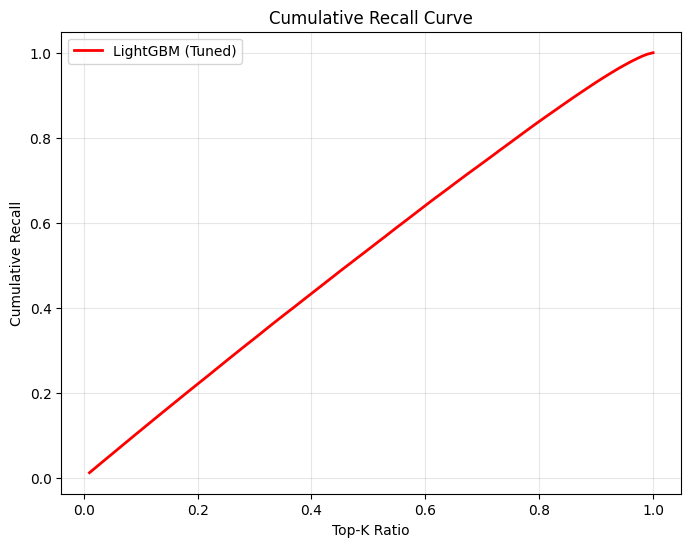

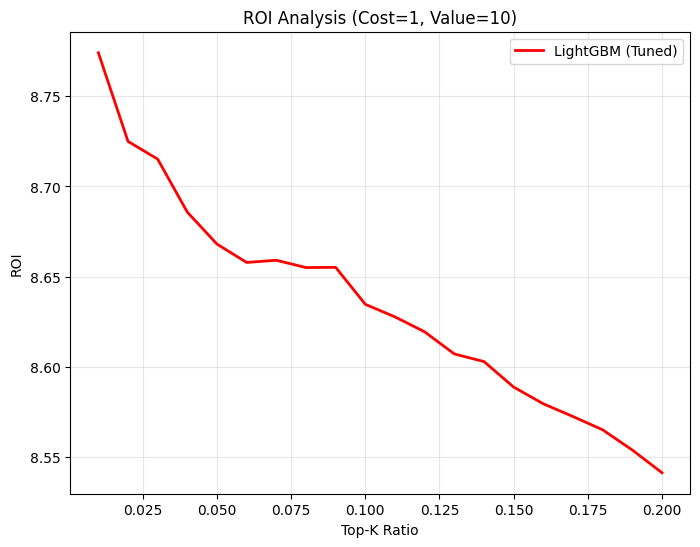


Accuracy: 0.7154
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.56      0.34     13531
           1       0.92      0.74      0.82     88302

    accuracy                           0.72    101833
   macro avg       0.58      0.65      0.58    101833
weighted avg       0.83      0.72      0.76    101833



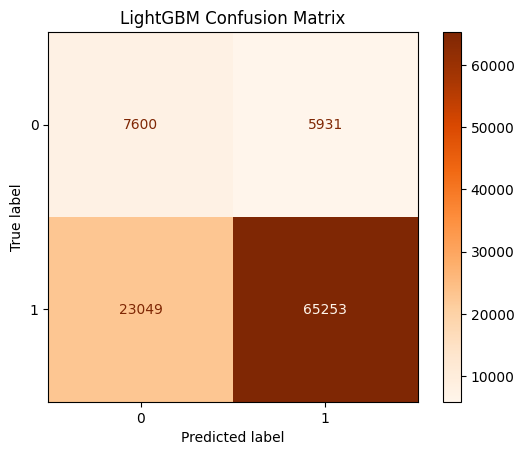

Calculating Feature Importance...


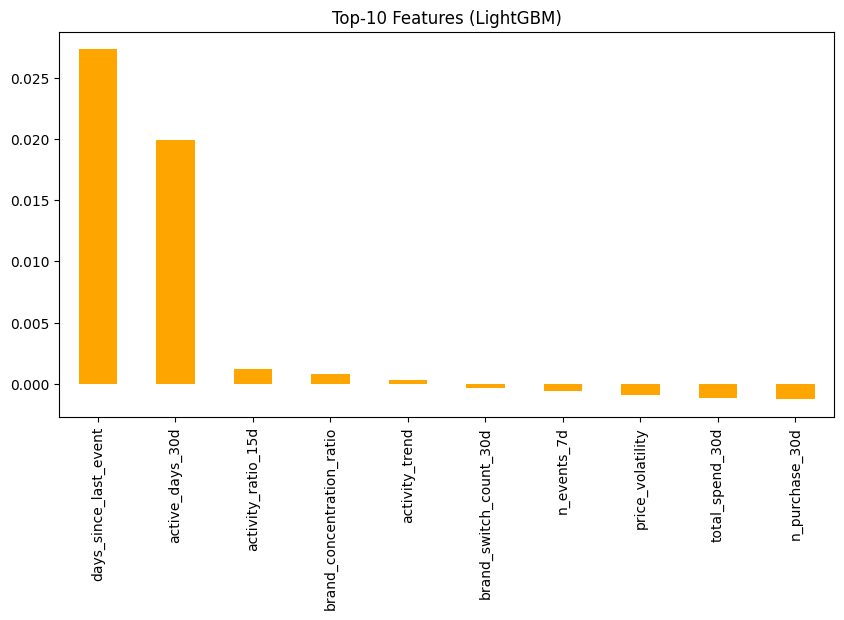

In [37]:
# 예측
prob_lgbm = best_lgbm.predict_proba(X_test)[:,1]

# --- Cumulative Recall ---
def cumulative_recall(y, p, steps=100):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    total = df.y.sum()
    xs, ys = [], []
    for k in range(1, steps+1):
        r = k/steps
        ys.append(df.iloc[:int(len(df)*r)].y.sum()/total)
        xs.append(r)
    return xs, ys

x, r_lgbm = cumulative_recall(y_test.values, prob_lgbm)

plt.figure(figsize=(8, 6))
plt.plot(x, r_lgbm, label="LightGBM (Tuned)", linewidth=2, color='red')
plt.xlabel("Top-K Ratio")
plt.ylabel("Cumulative Recall")
plt.title("Cumulative Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- ROI Analysis ---
COST = 1
VALUE = 10
def roi_curve(y, p):
    df = pd.DataFrame({"y":y,"p":p}).sort_values("p", ascending=False)
    ratios = np.linspace(0.01, 0.2, 20)
    rois = []
    for r in ratios:
        k = int(len(df)*r)
        if k == 0: k = 1
        hit = df.iloc[:k].y.sum()
        rois.append((hit*VALUE - k*COST)/(k*COST))
    return ratios, rois

x, roi_lgbm = roi_curve(y_test.values, prob_lgbm)

plt.figure(figsize=(8, 6))
plt.plot(x, roi_lgbm, label="LightGBM (Tuned)", linewidth=2, color='red')
plt.xlabel("Top-K Ratio")
plt.ylabel("ROI")
plt.title(f"ROI Analysis (Cost={COST}, Value={VALUE})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Classification Report ---
y_pred_lgbm = (prob_lgbm >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_lgbm)
print(f"\nAccuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_lgbm)
ConfusionMatrixDisplay(cm).plot(values_format="d", cmap='Oranges')
plt.title("LightGBM Confusion Matrix")
plt.show()

# --- Feature Importance ---
print("Calculating Feature Importance...")
imp = permutation_importance(best_lgbm, X_test, y_test, n_repeats=5, random_state=42)
plt.figure(figsize=(10, 5))
pd.Series(imp.importances_mean, index=X_test.columns)\
  .sort_values(ascending=False).head(10)\
  .plot(kind="bar", title="Top-10 Features (LightGBM)", color='orange')
plt.show()

# 튜닝 2차

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, classification_report, f1_score,
    precision_recall_curve, auc
)

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
features = pd.read_parquet("/Users/kimjiwoo/Documents/SKN23-2nd-3Team/data/features_ml_clean.parquet")
labels = pd.read_parquet("/Users/kimjiwoo/Documents/SKN23-2nd-3Team/data/labels.parquet")


features["user_id"] = features["user_id"].astype(str)
labels["user_id"]   = labels["user_id"].astype(str)
features["anchor_time"] = pd.to_datetime(features["anchor_time"])
labels["anchor_time"]   = pd.to_datetime(labels["anchor_time"])

df = features.merge(
    labels[["user_id","anchor_time","label","split"]],
    on=["user_id","anchor_time"],
    how="inner",
    validate="one_to_one"
)

# [중요] m2(이탈) = 1, Active = 0
df["y_bin"] = (df["label"] == "m2").astype(int)

feature_cols = [c for c in df.columns if c not in ["user_id","anchor_time","label","split","y_bin"]]

X_train = df[df.split=="train"][feature_cols]
y_train = df[df.split=="train"]["y_bin"]
X_test  = df[df.split=="test"][feature_cols]
y_test  = df[df.split=="test"]["y_bin"]

print(f"X_train.shape : {X_train.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"X_test.shape : {X_test.shape}")
print(f"y_test.shape : {y_test.shape}")

X_train.shape : (574092, 14)
y_train.shape : (574092,)
X_test.shape : (101833, 14)
y_test.shape : (101833,)


In [43]:
# ------------------------------------------------------------------------------
# 2. 모델 튜닝 (scale_pos_weight 적용)
# ------------------------------------------------------------------------------
print("🚀 Tuning LightGBM for Balance...")

# 이탈자(1) 비율 계산
neg, pos = np.bincount(y_train)
auto_weight = neg / pos # 이론적 최적 가중치 (~4~5 정도 예상)
print(f"ℹ️ 이론적 Class Weight (Auto): {auto_weight:.2f}")

lgbm_base = LGBMClassifier(
    random_state=42,
    n_jobs=1,                # 튜닝 시 충돌 방지
    boost_from_average=False,
    verbose=-1
)

# [핵심] is_unbalance 대신 scale_pos_weight를 범위로 탐색
param_dist = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 63],
    'max_depth': [10, 15, -1],
    'min_child_samples': [20, 50],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    # 가중치를 너무 세게 주지 않고 적절히 조절 (1: 기본, auto: 최대, 그 사이 값들)
    'scale_pos_weight': [1, 2, 3, auto_weight] 
}

search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1', # Recall과 Precision의 조화평균인 F1-Score 최적화
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_lgbm = search.best_estimator_

print(f"\n✅ Best Params: {search.best_params_}")

🚀 Tuning LightGBM for Balance...
ℹ️ 이론적 Class Weight (Auto): 0.24
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✅ Best Params: {'subsample': 0.7, 'scale_pos_weight': 2, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [44]:
# ------------------------------------------------------------------------------
# 3. 최적의 Threshold 찾기 (Threshold Tuning)
# ------------------------------------------------------------------------------
# 확률값 예측
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

# Threshold별 F1 Score 계산
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for th in thresholds:
    pred = (y_proba >= th).astype(int)
    f1_scores.append(f1_score(y_test, pred))

# F1 Score가 가장 높은 Threshold 선택
best_th = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"\n🔥 Best Threshold Found: {best_th:.2f}")
print(f"🔥 Max F1-Score: {best_f1:.4f}")


🔥 Best Threshold Found: 0.57
🔥 Max F1-Score: 0.9306



Accuracy: 0.8714

Classification Report (Balanced):
              precision    recall  f1-score   support

           0       0.64      0.07      0.13     13531
           1       0.87      0.99      0.93     88302

    accuracy                           0.87    101833
   macro avg       0.76      0.53      0.53    101833
weighted avg       0.84      0.87      0.82    101833



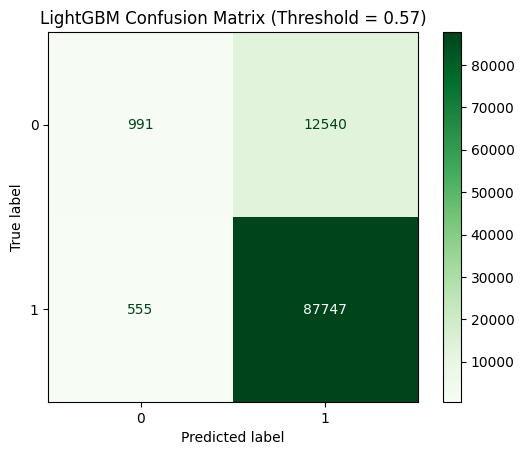

🏆 Final PR-AUC: 0.9332


In [45]:
# 4. 최종 평가 (New Threshold 적용)
# ------------------------------------------------------------------------------
# 최적 임계값 적용
y_pred_tuned = (y_proba >= best_th).astype(int)

# 정확도 및 리포트
acc = accuracy_score(y_test, y_pred_tuned)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification Report (Balanced):")
print(classification_report(y_test, y_pred_tuned))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
ConfusionMatrixDisplay(cm).plot(values_format="d", cmap='Greens')
plt.title(f"LightGBM Confusion Matrix (Threshold = {best_th:.2f})")
plt.show()

# PR Curve 확인
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"🏆 Final PR-AUC: {pr_auc:.4f}")

# 3차 시도

In [50]:
import optuna
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

# --------------------------------------------------------------------------------
# 1. 목표 함수 정의 (Recall 중심 튜닝)
# --------------------------------------------------------------------------------
def objective(trial):
    # [전략 1] 가중치를 더 공격적으로 탐색 (Recall 상승 효과)
    # 1.0(동등) ~ 10.0(이탈자를 10배 더 중요하게) 사이에서 탐색
    weight_candidate = trial.suggest_float('scale_pos_weight', 1.0, 10.0)
    
    param = {
        'objective': 'binary',
        'metric': 'custom',   # 우리가 직접 정의한 점수(F2)를 쓸 것임
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': 1,
        'scale_pos_weight': weight_candidate,
        
        # 모델 복잡도 파라미터
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
    }

    model = LGBMClassifier(**param)
    
    # 3-Fold 교차 검증
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f2_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        # [전략 2] F2-Score 계산 (beta=2: Recall을 Precision보다 2배 중요하게 봄)
        score = fbeta_score(y_val, y_pred, beta=2)
        f2_scores.append(score)
    
    return np.mean(f2_scores)

# --------------------------------------------------------------------------------
# 2. 튜닝 실행
# --------------------------------------------------------------------------------
print("🚀 Recall 특화(F2-Score) 튜닝 시작...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f"\n🏆 Best F2-Score: {study.best_value:.4f}")
print("🏆 Best Params (High Recall):")
print(study.best_params)

# --------------------------------------------------------------------------------
# 3. 최적 모델 학습 및 결과 확인
# --------------------------------------------------------------------------------
best_params = study.best_params
final_model = LGBMClassifier(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# 평가
from sklearn.metrics import classification_report
y_pred = final_model.predict(X_test)
print("\n📊 Final Classification Report:")
print(classification_report(y_test, y_pred))

[I 2026-01-11 11:31:41,620] A new study created in memory with name: no-name-f4cce572-befa-4349-97ea-9bffd316a424


🚀 Recall 특화(F2-Score) 튜닝 시작...


[I 2026-01-11 11:35:05,383] Trial 0 finished with value: 0.9534341207178773 and parameters: {'scale_pos_weight': 3.6026325290175003, 'n_estimators': 1747, 'learning_rate': 0.005553857883708652, 'num_leaves': 121, 'max_depth': 11, 'min_child_samples': 97, 'subsample': 0.8199316854750097, 'colsample_bytree': 0.8593768496006667}. Best is trial 0 with value: 0.9534341207178773.
[I 2026-01-11 11:37:11,293] Trial 1 finished with value: 0.9531924152545302 and parameters: {'scale_pos_weight': 8.484588900749412, 'n_estimators': 1903, 'learning_rate': 0.04151969443745857, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.5012237672125407, 'colsample_bytree': 0.6191108354652153}. Best is trial 0 with value: 0.9534341207178773.
[I 2026-01-11 11:38:56,568] Trial 2 finished with value: 0.9532130181304365 and parameters: {'scale_pos_weight': 6.918242374312288, 'n_estimators': 1422, 'learning_rate': 0.05241836567528719, 'num_leaves': 44, 'max_depth': 15, 'min_child_samples': 65


🏆 Best F2-Score: 0.9537
🏆 Best Params (High Recall):
{'scale_pos_weight': 6.007377484728572, 'n_estimators': 895, 'learning_rate': 0.00780188138141139, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 80, 'subsample': 0.7106537206659299, 'colsample_bytree': 0.7255589687765194}

📊 Final Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.01      0.02     13531
           1       0.87      1.00      0.93     88302

    accuracy                           0.87    101833
   macro avg       0.87      0.51      0.48    101833
weighted avg       0.87      0.87      0.81    101833



In [49]:
!pip install optuna

  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.18.0-py3-none-any.whl.metadata (7.2 kB)
  Using cached colorlog-6.10.1-py3-none-any.whl.metadata (11 kB)
  Using cached sqlalchemy-2.0.45-py3-none-any.whl.metadata (9.5 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
Using cached optuna-4.6.0-py3-none-any.whl (404 kB)
Using cached sqlalchemy-2.0.45-py3-none-any.whl (1.9 MB)
Using cached colorlog-6.10.1-py3-none-any.whl (11 kB)
Using cached mako-1.3.10-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [optuna]2m4/5 [optuna]]
